#Importing Dataset From Kaggle

In [1]:
!pip install -q kaggle

In [2]:
!mkdir -p ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 98% 761M/778M [00:18<00:00, 45.4MB/s]
100% 778M/778M [00:18<00:00, 45.1MB/s]


#unzipping the dataset

In [6]:
!unzip /content/covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

#data preprocessing

In [7]:
#setup
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import gc
import cv2
import math
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [8]:
cd /content

/content


In [9]:
mkdir Train

In [10]:
mkdir Test

In [11]:
cd /content/Train

/content/Train


In [12]:
mkdir covid

In [13]:
mkdir normal

In [14]:
cd /content/Test

/content/Test


In [15]:
mkdir covid

In [16]:
mkdir normal

In [17]:
cd /content

/content


*moving* 3000 images to train>covid

In [18]:
ls -Q /content/COVID-19_Radiography_Dataset/COVID/images | head -3000 | xargs -i mv /content/COVID-19_Radiography_Dataset/COVID/images/{} /content/Train/covid/

In [19]:
ls -Q /content/COVID-19_Radiography_Dataset/Normal/images | head -3000 | xargs -i mv /content/COVID-19_Radiography_Dataset/Normal/images/{} /content/Train/normal/

In [20]:
ls -Q /content/COVID-19_Radiography_Dataset/COVID/images | head -600 | xargs -i mv /content/COVID-19_Radiography_Dataset/COVID/images/{} /content/Test/covid/

In [21]:
ls -Q /content/COVID-19_Radiography_Dataset/Normal/images | head -600 | xargs -i mv /content/COVID-19_Radiography_Dataset/Normal/images/{} /content/Test/normal/

In [22]:
height=224
width=224
channels=3
batch_size=32
img_shape=(height, width, channels)
img_size=(height, width)

#Applying data augmentation & on training and validation dataset

In [23]:
Train_Valid_gen=ImageDataGenerator(rescale=(1./255) , rotation_range=180, width_shift_range=0.2, 
                        height_shift_range=0.2, horizontal_flip=True, validation_split=0.1)

In [24]:
train_gen= Train_Valid_gen.flow_from_directory(directory = '/content/Train', target_size=img_size, subset='training',
                                               batch_size=batch_size,  class_mode='categorical', seed=58)

Found 5400 images belonging to 2 classes.


In [25]:
Valid_gen= Train_Valid_gen.flow_from_directory(directory = '/content/Train', target_size=img_size, subset='validation',
                                               batch_size=batch_size,  class_mode='categorical',seed=12)

Found 600 images belonging to 2 classes.


#data visulization

In [26]:
Valid_gen.class_indices

{'covid': 0, 'normal': 1}

In [27]:
train_gen.class_indices

{'covid': 0, 'normal': 1}

In [28]:
train_images, train_labels = next(train_gen)
val_images, val_labels = next(Valid_gen)

In [29]:
print("Train Images shape " , train_images.shape)
print("Valid Images shape " , train_images.shape)

Train Images shape  (32, 224, 224, 3)
Valid Images shape  (32, 224, 224, 3)


In [30]:
def show_image_samples(gen):
    class_dict=gen.class_indices
    class_names=list( class_dict.keys())       
    images,labels=next(gen) # get a sample batch from the generator   
    plt.figure(figsize=(10, 10))
    length=len(labels)
 
    for i in range(6):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        index=np.argmax(labels[i])
        class_name=class_names[index]
        plt.title(class_name, color='black', fontsize=16)
        plt.axis('off')
    plt.show()
plt. style. use('default')

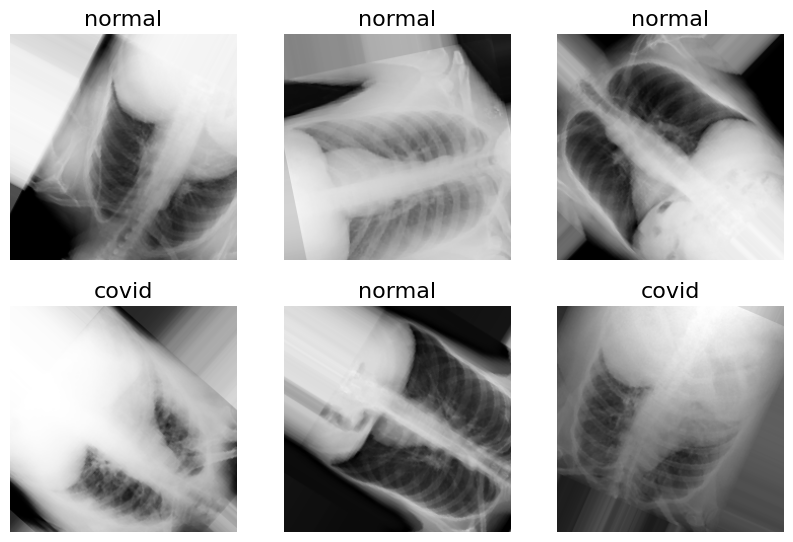

In [31]:
show_image_samples(train_gen)

#Transfer Learning

In [32]:
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers.merge import concatenate
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense,Conv2D,Input,GlobalAveragePooling2D
from tensorflow.keras import layers  
from tensorflow.keras.applications import VGG16

In [36]:
# Input Layer ----> Transfer Learning Algorithm ---> Output Layer 

def build_model():
    # use imagenet - pre-trainined weights for images
    baseModel = VGG16(weights= 'imagenet', include_top = False, input_shape=(img_shape))

    for layer in baseModel.layers[:-3]:
      layer.trainable = False

    headModel = baseModel.output
    headModel = GlobalAveragePooling2D()(headModel)
    headModel = BatchNormalization()(headModel)
    
    headModel = Dense(128, activation="relu")(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = BatchNormalization()(headModel)
    
    headModel = Dense(2, activation="softmax")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    optimizers = RMSprop(learning_rate=0.00001)
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizers, metrics = ['accuracy'])

    return model
model=build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [37]:
from keras.callbacks import ModelCheckpoint
import datetime
import keras


checkpoint_filepath = '/content/VGG16.h5'
callbacks = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,   save_weights_only=True,
                           monitor='val_loss',    mode='min',   save_best_only=True,   verbose=3)




cnnModel=model.fit( train_gen, validation_data=Valid_gen, epochs=50,  verbose=1, callbacks=[callbacks])



Epoch 1/50
169/169 [==============================] - ETA: 0s - loss: 0.5709 - accuracy: 0.7298
Epoch 1: val_loss improved from inf to 0.66368, saving model to /content/VGG16.h5
169/169 [==============================] - 83s 476ms/step - loss: 0.5709 - accuracy: 0.7298 - val_loss: 0.6637 - val_accuracy: 0.5733
Epoch 2/50
169/169 [==============================] - ETA: 0s - loss: 0.4311 - accuracy: 0.8017
Epoch 2: val_loss improved from 0.66368 to 0.45476, saving model to /content/VGG16.h5
169/169 [==============================] - 80s 471ms/step - loss: 0.4311 - accuracy: 0.8017 - val_loss: 0.4548 - val_accuracy: 0.8100
Epoch 3/50
169/169 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.8341
Epoch 3: val_loss improved from 0.45476 to 0.35880, saving model to /content/VGG16.h5
169/169 [==============================] - 81s 478ms/step - loss: 0.3755 - accuracy: 0.8341 - val_loss: 0.3588 - val_accuracy: 0.8467
Epoch 4/50
169/169 [==============================] - ET

AttributeError: ignored

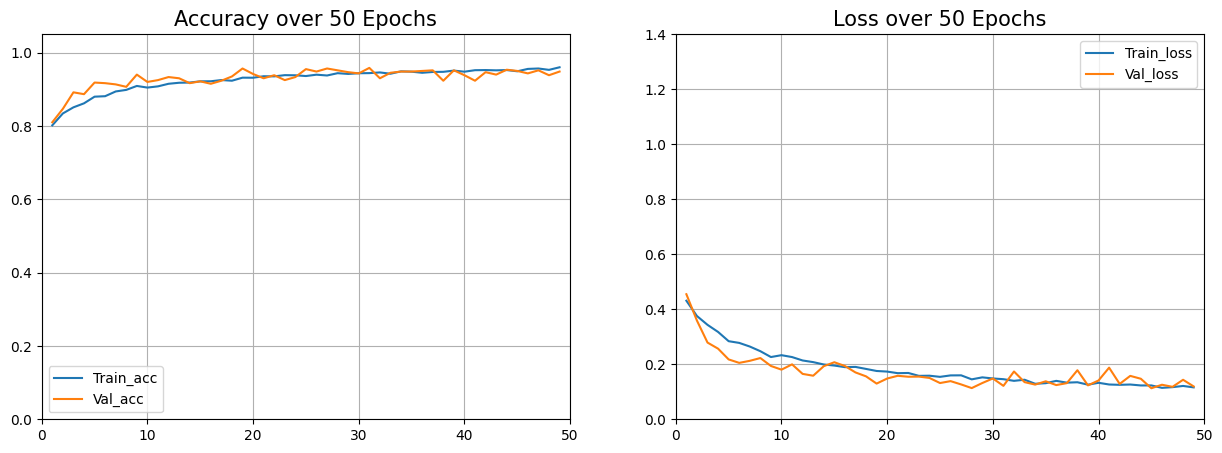

In [38]:
#Plot the accuracy and loss graphs
import matplotlib.pyplot as plt

def plot_acc_loss(result, epochs):
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.xlim(0,epochs)
    plt.ylim(0, 1.05)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Val_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.xlim(0,epochs)
    plt.ylim(0, 1.4)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Val_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(cnnModel, 50)

In [39]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_dir =  '/content/Test'
eval_generator = test_datagen.flow_from_directory(test_dir,target_size=img_size,batch_size=1, 
                                                  shuffle=False, seed=42, class_mode="categorical")
eval_generator.reset()
#Evalute the trained model on evaluate generator
eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator)), 
                           use_multiprocessing = False,  verbose = 1,
                           workers=1     )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 1200 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


1200/1200 [==============================] - 15s 11ms/step - loss: 0.1130 - accuracy: 0.9583
Test loss: 0.11296816170215607
Test accuracy: 0.9583333134651184


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  import sys


[[556  44]
 [  6 594]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       600
           1       0.93      0.99      0.96       600

    accuracy                           0.96      1200
   macro avg       0.96      0.96      0.96      1200
weighted avg       0.96      0.96      0.96      1200



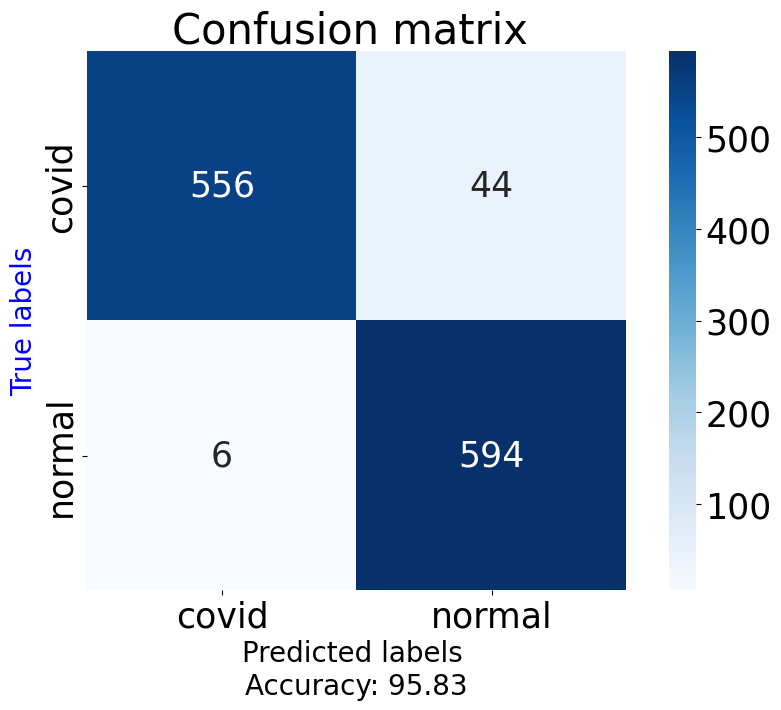

In [40]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
filenames = eval_generator.filenames
nb_samples = len(filenames)
eval_generator.reset()  
predict = model.predict_generator(eval_generator,steps = np.ceil(len(eval_generator)))
pp=predict
predict=np.argmax(predict, axis=-1)
classes= eval_generator.classes[eval_generator.index_array]
acc=sum(predict==classes)/len(predict)
names=eval_generator.class_indices
cm = confusion_matrix(classes, predict)
print(cm)
print(classification_report(classes,predict))
import seaborn as sns
plt.figure(figsize=(11,7))
x_axis_labels = eval_generator.class_indices
y_axis_labels = eval_generator.class_indices
plt.rcParams.update({'font.size': 25})
sns.heatmap(confusion_matrix(classes, predict),xticklabels=x_axis_labels,
            yticklabels=y_axis_labels,annot= True, fmt='',cmap = 'Blues')
plt.imshow(cm, cmap='binary' )
plt.xlabel('Predicted labels \nAccuracy: {:0.2f}'.format(acc*100),fontsize=20)
plt.ylabel("True labels",fontsize=20,color='b')
plt.title('Confusion matrix ')
plt.show()

covid (0.999)
normal (0.000796)


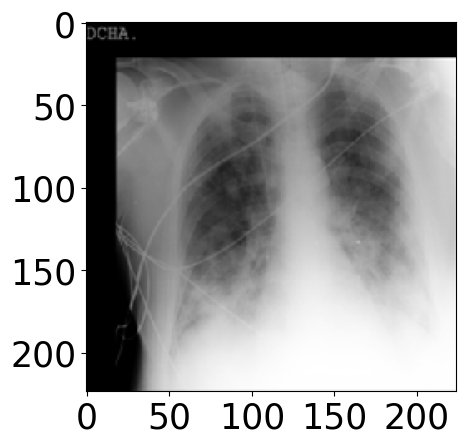

In [41]:
img = image.load_img('/content/Test/covid/COVID-45.png',target_size=(img_shape))
img = image.img_to_array(img)
img = img/255.

classes = ['covid','normal']
proba = model.predict(img.reshape(1,224,224,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(2):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)
plt.style.use('classic')

normal (0.999)
covid (0.00128)


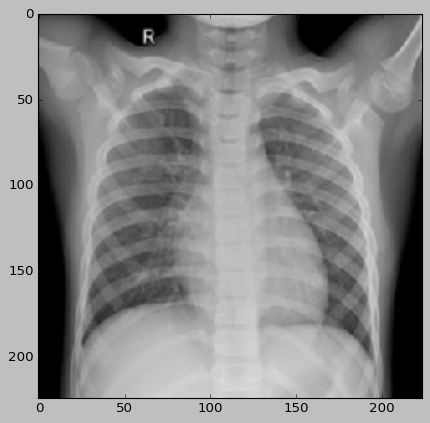

In [42]:
img = image.load_img('/content/Test/normal/Normal-352.png',target_size=(img_shape))
img = image.img_to_array(img)
img = img/255.

classes = ['covid','normal']
proba = model.predict(img.reshape(1,224,224,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(2):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)
plt.style.use('classic')